# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
#pip install pandas-profiling

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
#import ydata_profiling

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor, Pool


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [ ]:
data = df.copy()

In [ ]:
data['VehicleType']

0                 NaN
1               coupe
2                 suv
3               small
4               small
             ...     
354364            NaN
354365            NaN
354366    convertible
354367            bus
354368          wagon
Name: VehicleType, Length: 354369, dtype: object

In [ ]:
data['VehicleType'] = data['VehicleType'].fillna(data.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

In [ ]:
data['VehicleType']

0               sedan
1               coupe
2                 suv
3               small
4               small
             ...     
354364          sedan
354365            NaN
354366    convertible
354367            bus
354368          wagon
Name: VehicleType, Length: 354369, dtype: object

In [ ]:
data.groupby('Model')['FuelType']

In [ ]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 50), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

In [ ]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [ ]:
#profile = df.profile_report(title='Pandas Profiling Report', progress_bar=False)
#profile

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

* Price — цена (евро) — целевой признак

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Предобработка данных

Для задачи предсказания цены не обязательно держать в датасете некоторые столбцы:

* NumberOfPictures
* PostalCode
* DateCrawled
* LastSeen

Сразу удалю дубликаты и неинформативные столбцы.

In [ ]:
df = df.drop_duplicates().drop(['NumberOfPictures', 'DateCrawled', 'LastSeen', 'RegistrationMonth', 'PostalCode'], axis=1).reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
 10  DateCreated       354365 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


#### DateCreated

Удалю строки, в которых дата создания объявления меньше даты регистрации авто.

In [ ]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['DateCreated'] = pd.DataFrame(pd.DatetimeIndex(df['DateCreated']).year)
df['DateCreated'] = df['DateCreated'].astype('int64')

In [ ]:
df.query('RegistrationYear > DateCreated')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no,2016
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no,2016
48,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN,2016
51,2000,NaN,2017,manual,90,punto,150000,gasoline,fiat,yes,2016
57,2399,NaN,2018,manual,64,other,125000,NaN,seat,no,2016
...,...,...,...,...,...,...,...,...,...,...,...
354108,3600,NaN,2017,manual,86,transit,150000,gasoline,ford,NaN,2016
354136,1000,NaN,2017,manual,101,a4,150000,NaN,audi,NaN,2016
354199,2140,NaN,2018,manual,80,fiesta,150000,NaN,ford,no,2016
354249,1250,NaN,2018,NaN,0,corsa,150000,petrol,opel,NaN,2016


In [ ]:
df = df.query('~(RegistrationYear > DateCreated)')

Теперь удалю столбец DateCreated как неинформативный.

In [ ]:
df = df.drop(['DateCreated'], axis=1).reset_index(drop=True)

#### Price

В столбце Price есть некорректные значения — когда цена равна нулю. Т.к. это целевой признак, будет неправильно заполнять это значение чем-то.

In [ ]:
print(f'Количество нулевых значений равно {(df["Price"][df["Price"] == 0].count())}.')

Количество нулевых значений равно 10021.


In [ ]:
print(f'Это примерно {(df["Price"][df["Price"] == 0].count() / len(df) * 100).round(3)}% от общего количества. Я удалю эти значения.')

Это примерно 2.949% от общего количества. Я удалю эти значения.


In [ ]:
df = df.loc[df['Price'] != 0]

In [ ]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
339829,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
339831,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
339832,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
339833,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


#### VehicleType

В столбце большой процент пропусков, удалять их опасно. Заменю заглушкой.

In [ ]:
print(f'Количество пропусков — {(df["VehicleType"].isna().sum() / len(df) * 100).round(3)}%')
df['VehicleType'].isna().sum()

Количество пропусков — 6.061%


19990

In [ ]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

#### RegistrationYear

В этом столбце есть очень странные года!

In [ ]:
df['RegistrationYear'].describe()

count    329814.000000
mean       2002.461727
std          12.963860
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

<AxesSubplot:>

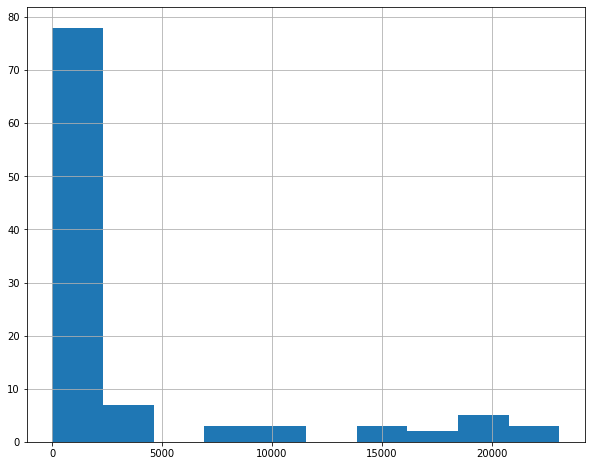

In [ ]:
df['RegistrationYear'].value_counts().hist()

In [ ]:
print(f'Количество некорректных данных — {100 - (df["RegistrationYear"][df["RegistrationYear"] <= 2020][df["RegistrationYear"] >= 1920].count() / len(df) * 100).round(3)}%')

Количество некорректных данных — 0.03300000000000125%


In [ ]:
df = df.loc[df['RegistrationYear'].isin(df['RegistrationYear'][df["RegistrationYear"] <= 2020][df["RegistrationYear"] >= 1920])]

#### Gearbox

Это значение восстановить не получится.

In [ ]:
print(f'Количество пропусков — {(df["Gearbox"].isna().sum() / len(df) * 100).round(3)}%')
df['Gearbox'].isna().sum()

Количество пропусков — 4.72%


15563

In [ ]:
df = df.loc[~df['Gearbox'].isna()]

#### Model

Это значение восстановить не получится.

In [ ]:
print(f'Количество пропусков — {(df["Model"].isna().sum() / len(df) * 100).round(3)}%')
df['Model'].isna().sum()

Количество пропусков — 4.112%


12919

In [ ]:
df = df.loc[~df['Model'].isna()]

#### FuelType

In [ ]:
print(f'Количество пропусков — {(df["FuelType"].isna().sum() / len(df) * 100).round(3)}%')
df['FuelType'].isna().sum()

Количество пропусков — 4.884%


14711

In [ ]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

#### Repaired

Вероятнее всего пропущены значения "no".

In [ ]:
df['Repaired'].value_counts()

no     225349
yes     29951
Name: Repaired, dtype: int64

In [ ]:
print(f'Количество пропусков — {(df["Repaired"].isna().sum() / len(df) * 100).round(3)}%')
df['Repaired'].isna().sum()

Количество пропусков — 15.246%


45923

In [ ]:
df["Repaired"].fillna("no", inplace=True)

#### Power

Много нулевых и околонулевых значений. Заполню их медианой.

In [ ]:
print(f'Количество некорректных данных — {(df["Power"][df["Power"] <= 50].count() / len(df) * 100).round(3)}%')
df['Power'][df["Power"] == 0].count()

Количество некорректных данных — 9.565%


20280

In [ ]:
df['Power'].describe()

count    301223.000000
mean        116.002779
std         179.425982
min           0.000000
25%          75.000000
50%         108.000000
75%         144.000000
max       20000.000000
Name: Power, dtype: float64

In [ ]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 50), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

In [ ]:
df = df.reset_index()
del df['index']

#### Посмотрим на корреляцию численных признаков.

In [ ]:
df.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,101,golf,150000,petrol,volkswagen,no
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no


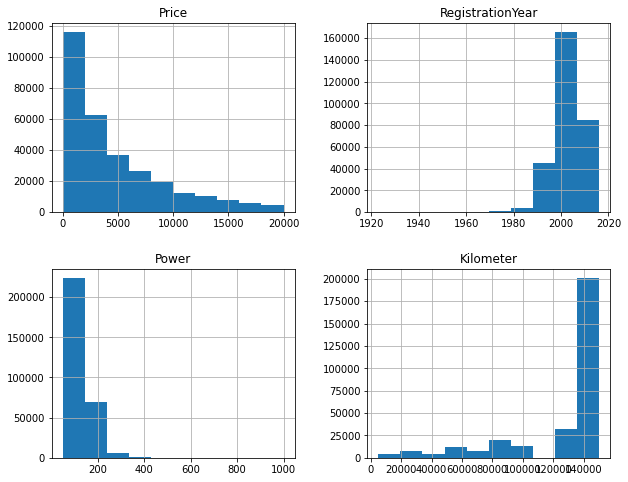

In [ ]:
df[['Price', 'RegistrationYear', 'Power', 'Kilometer']].hist()
plt.show()

In [ ]:
df[['Price', 'RegistrationYear', 'Power', 'Kilometer']].corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.494320,0.496679,-0.386078
RegistrationYear,0.494320,1.000000,0.112637,-0.299452
Power,0.496679,0.112637,1.000000,0.095269
Kilometer,-0.386078,-0.299452,0.095269,1.000000


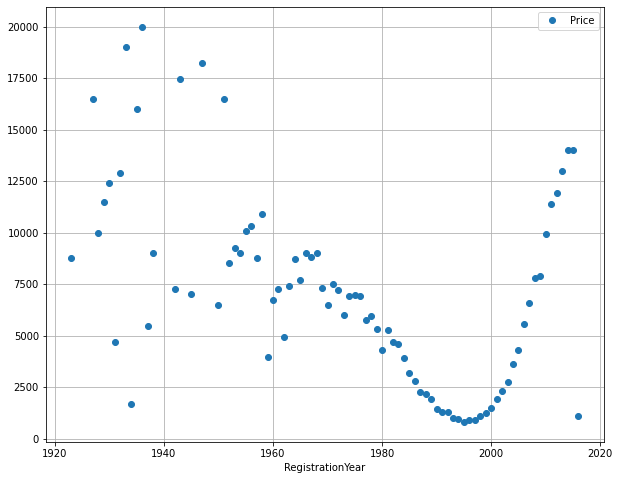

In [ ]:
price_per_year = (
    df.pivot_table(index='RegistrationYear',
                   values='Price',
                   aggfunc=('median')).sort_values(by='Price')
    .plot(style='o', grid=True)
)
plt.show()

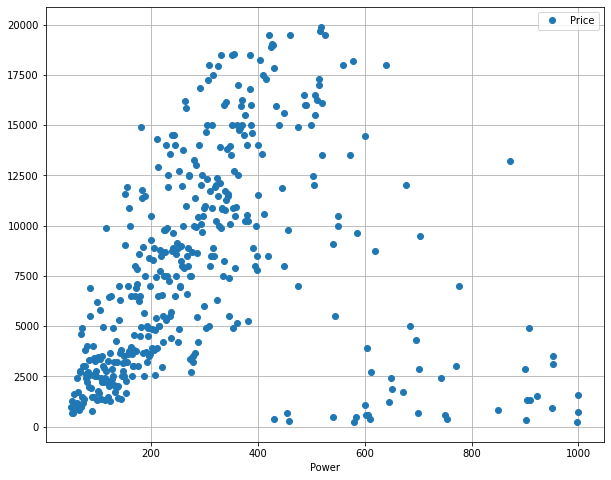

In [ ]:
price_per_power = (
    df.pivot_table(index='Power',
                   values='Price',
                   aggfunc=('median')).sort_values(by='Price')
    .plot(style='o', grid=True)
)
plt.show()

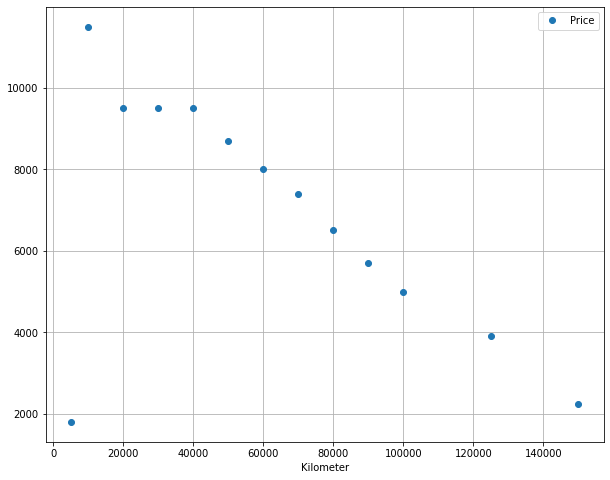

In [ ]:
price_per_kilometer = (
    df.pivot_table(index='Kilometer',
                   values='Price',
                   aggfunc=('median')).sort_values(by='Price')
    .plot(style='o', grid=True)
)
plt.show()

**Вывод:**
* Автомобили, выпущенные в середине прошлого века, могут стоить как новые, их можно назвать антиквариатом. Старыми считаются автомобили выпущенные с 60 по 00 года, на них цена сильно ниже. Новые — выпщуенные после 00 годов, цена растет пропорционально новизне.
* Цена растет по мере повышения мощности автомобиля, но на высоких значениях видно падение стоимости.
* Чем выше пробег у автомобиля, тем меньше он будет стоить!

### Стратификация выборки.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df.drop('Price', axis=1), df['Price'], test_size=.4, random_state=666)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=.5, random_state=666)

### Кодирование категориальных признаков!

In [ ]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(X_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
data1 = pd.DataFrame(enc.transform(X_train), columns=X_train.columns)

data1 = data1.reset_index()
del data1['index']
X_train = X_train.reset_index()
del X_train['index']

X_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']] = data1[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']].astype(int)

In [ ]:
data2 = pd.DataFrame(enc.transform(X_val), columns=X_val.columns)

data2 = data2.reset_index()
del data2['index']
X_val = X_val.reset_index()
del X_val['index']

X_val[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']] = data2[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']].astype(int)

In [ ]:
data3 = pd.DataFrame(enc.transform(X_test), columns=X_test.columns)

data3 = data3.reset_index()
del data3['index']
X_test = X_test.reset_index()
del X_test['index']

X_test[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']] = data3[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']].astype(int)

In [ ]:
X_train.head(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2,1998,1,90,165,150000,6,35,0
1,4,1997,1,55,82,150000,6,24,1
2,1,2010,1,122,79,100000,6,21,0
3,7,2000,1,75,142,150000,6,37,0
4,4,1992,1,109,94,150000,6,20,0


In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,300968.000000,300968.000000,300968.000000,300968.000000
mean,4761.712046,2002.814309,121.079460,128678.597060
std,4589.126054,6.432569,52.610021,36550.559539
min,1.000000,1923.000000,51.000000,5000.000000
25%,1299.000000,1999.000000,79.000000,125000.000000
50%,3000.000000,2003.000000,113.000000,150000.000000
75%,6900.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,1000.000000,150000.000000


### Стандартизиция  признаков.

In [ ]:
numeric = ['RegistrationYear', 'Power', 'Model', 'Kilometer', 'Brand']

scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2,-0.744168,1,-0.592559,0.818475,0.583369,6,1.125654,0
1,4,-0.899188,1,-1.260242,-0.364183,0.583369,6,0.278773,1
2,1,1.116064,1,0.017894,-0.406930,-0.785683,6,0.047806,0
3,7,-0.434130,1,-0.878709,0.490751,0.583369,6,1.279632,0
4,4,-1.674284,1,-0.230103,-0.193197,0.583369,6,-0.029184,0


**Вывод:**
* Избавился от пропусков и выбросов
* Удалил неинформативные столбцы
* Восстановил пропущенные значения
* Закодировал категориальные признаки методом Ordinal Encoding
* Разбил выборку на тренировочную, тестовую и валидационную
* Стандартизировал признаки

## Обучение моделей

### Random Forest Regressor

**Добавил этот параметр. Метрика стала лучше.**

In [ ]:
parameters={"max_depth" : [None] + [i for i in range(2, 11)],
           'n_estimators': [25,50,100,150]}
           #"n_estimators":[None] + [i for i in range(25, 150)]}


regr = RandomForestRegressor(random_state=666, max_features=4)

tuning_model_rfr = GridSearchCV(
    regr,
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=10,
    n_jobs=-1
)

In [ ]:
tuning_model_rfr.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3; 1/40] START max_depth=None, n_estimators=25............................
[CV 1/3; 1/40] END ..........max_depth=None, n_estimators=25; total time=   4.7s
[CV 2/3; 1/40] START max_depth=None, n_estimators=25............................
[CV 2/3; 1/40] END ..........max_depth=None, n_estimators=25; total time=   4.8s
[CV 3/3; 1/40] START max_depth=None, n_estimators=25............................
[CV 3/3; 1/40] END ..........max_depth=None, n_estimators=25; total time=   5.0s
[CV 1/3; 2/40] START max_depth=None, n_estimators=50............................
[CV 1/3; 2/40] END ..........max_depth=None, n_estimators=50; total time=   9.9s
[CV 2/3; 2/40] START max_depth=None, n_estimators=50............................
[CV 2/3; 2/40] END ..........max_depth=None, n_estimators=50; total time=   8.9s
[CV 3/3; 2/40] START max_depth=None, n_estimators=50............................
[CV 3/3; 2/40] END ..........max_depth=None, n_

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_features=4, random_state=666),
             n_jobs=-1,
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=10)

In [ ]:
tuning_model_rfr.best_params_

{'max_depth': None, 'n_estimators': 150}

In [ ]:
%%time
model = RandomForestRegressor(random_state=666,
                              max_features=4,
                              max_depth=None,
                              n_estimators=150,
                              verbose=10, n_jobs=-1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 150


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 150


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


building tree 4 of 150


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


building tree 5 of 150


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s


building tree 6 of 150


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.0s remaining:    0.0s


building tree 7 of 150


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.3s remaining:    0.0s


building tree 8 of 150


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s


building tree 9 of 150


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.9s remaining:    0.0s


building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   49.6s finished


RandomForestRegressor(max_features=4, n_estimators=150, n_jobs=-1,
                      random_state=666, verbose=10)

In [ ]:
%%time
y_pred_rfr = tuning_model_rfr.predict(X_val)
print(f'RMSE = {sqrt(mean_squared_error(y_val, y_pred_rfr))}')

RMSE = 1542.8969699912227
CPU times: user 4.09 s, sys: 0 ns, total: 4.09 s
Wall time: 4.18 s


### Decision Tree Regressor

In [ ]:
parameters={"max_depth" : [None] + [i for i in range(2, 11)],
           "min_samples_leaf":[None] + [i for i in range(2, 11)]}

regr = DecisionTreeRegressor(random_state=666)

tuning_model_dtr = GridSearchCV(
    regr,
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=10
)
tuning_model_dtr.fit(X_train, y_train)

In [ ]:
tuning_model_dtr.best_params_

{'max_depth': None, 'min_samples_leaf': 9}

In [ ]:
%%time
model = DecisionTreeRegressor(random_state=666,
                              max_depth=None,
                              min_samples_leaf=9)
model.fit(X_train, y_train)

CPU times: user 732 ms, sys: 11.5 ms, total: 743 ms
Wall time: 859 ms


DecisionTreeRegressor(min_samples_leaf=9, random_state=666)

In [ ]:
%%time
y_pred_dtr = tuning_model_dtr.predict(X_val)
print(f'RMSE = {sqrt(mean_squared_error(y_val, y_pred_dtr))}')

RMSE = 1746.0585982035789
CPU times: user 21.2 ms, sys: 3.95 ms, total: 25.2 ms
Wall time: 29.7 ms


### Catboost

In [ ]:
parameters =  {'depth': [6, 8],
               'l2_leaf_reg': [1, 3]}

cbr = CatBoostRegressor(random_state=666, iterations=1000)
tuning_model_cbr = GridSearchCV(
    cbr,
    param_grid=parameters,
    cv=3,
    verbose=10,
    n_jobs=-1,
    scoring='r2',
)
tuning_model_cbr.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START depth=6, l2_leaf_reg=1......................................


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 4503.3484364	total: 25.3ms	remaining: 25.3s
1:	learn: 4415.4350157	total: 49.8ms	remaining: 24.8s
2:	learn: 4332.1116361	total: 75ms	remaining: 24.9s
3:	learn: 4253.5339615	total: 99.2ms	remaining: 24.7s
4:	learn: 4173.9805497	total: 122ms	remaining: 24.3s
5:	learn: 4098.1552444	total: 148ms	remaining: 24.6s
6:	learn: 4025.5278805	total: 170ms	remaining: 24.1s
7:	learn: 3953.3759176	total: 198ms	remaining: 24.5s
8:	learn: 3882.3157550	total: 226ms	remaining: 24.9s
9:	learn: 3818.4460634	total: 253ms	remaining: 25.1s
10:	learn: 3756.4080133	total: 281ms	remaining: 25.3s
11:	learn: 3695.8740502	total: 310ms	remaining: 25.5s
12:	learn: 3635.0375290	total: 336ms	remaining: 25.5s
13:	learn: 3577.5803059	total: 365ms	remaining: 25.7s
14:	learn: 3521.6077565	total: 394ms	remaining: 25.9s
15:	learn: 3467.6288198	total: 422ms	remaining: 25.9s
16:	learn: 3416.8313883	total: 448ms	remaining: 25.9s
17:	learn: 3366.3686872	total: 475ms	remaining: 25.9s
18:	learn: 3321.6155487	total: 503ms

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f02e2e8c070>,
             n_jobs=-1, param_grid={'depth': [6, 8], 'l2_leaf_reg': [1, 3]},
             scoring='r2', verbose=10)

In [ ]:
tuning_model_cbr.best_params_

{'depth': 8, 'l2_leaf_reg': 1}

In [ ]:
%%time
model = CatBoostRegressor(random_state=666,
                          depth=8,
                          iterations=1000,
                          l2_leaf_reg=1)
model.fit(X_train, y_train)

0:	learn: 4495.4527152	total: 59.5ms	remaining: 59.5s
1:	learn: 4404.3158089	total: 101ms	remaining: 50.3s
2:	learn: 4315.8224340	total: 145ms	remaining: 48.1s
3:	learn: 4229.9756894	total: 191ms	remaining: 47.5s
4:	learn: 4146.9398383	total: 223ms	remaining: 44.4s
5:	learn: 4066.1945203	total: 260ms	remaining: 43.1s
6:	learn: 3988.3445752	total: 298ms	remaining: 42.2s
7:	learn: 3914.4689020	total: 330ms	remaining: 40.9s
8:	learn: 3842.8897165	total: 368ms	remaining: 40.5s
9:	learn: 3772.5076033	total: 402ms	remaining: 39.7s
10:	learn: 3705.6409609	total: 433ms	remaining: 38.9s
11:	learn: 3641.2296022	total: 471ms	remaining: 38.8s
12:	learn: 3579.0467646	total: 506ms	remaining: 38.4s
13:	learn: 3519.5538324	total: 540ms	remaining: 38s
14:	learn: 3460.3734209	total: 580ms	remaining: 38.1s
15:	learn: 3404.9353461	total: 612ms	remaining: 37.6s
16:	learn: 3351.8529890	total: 648ms	remaining: 37.5s
17:	learn: 3300.1601993	total: 687ms	remaining: 37.5s
18:	learn: 3249.0697335	total: 737ms	re

In [ ]:
%%time
y_pred_cbr = tuning_model_cbr.predict(X_val)
print(f'RMSE = {sqrt(mean_squared_error(y_val, y_pred_cbr))}')

RMSE = 1601.2234483284929
CPU times: user 148 ms, sys: 3.95 ms, total: 152 ms
Wall time: 150 ms


### LGBMRegressor

In [ ]:
params = {
    'max_depth': [None] + [i for i in range(2, 11)],
    'n_estimators': [25,50,100],
}

lgbmr = LGBMRegressor(random_state=666, learning_rate=.1)

tuning_model_lgbmr = GridSearchCV(
    lgbmr,
    param_grid=params,
    cv=3,
    verbose=10,
    n_jobs=-1,
    scoring='r2'
)

tuning_model_lgbmr.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START max_depth=None, n_estimators=25............................
[CV 1/3; 1/30] END ..........max_depth=None, n_estimators=25; total time=   2.0s
[CV 2/3; 1/30] START max_depth=None, n_estimators=25............................
[CV 2/3; 1/30] END ..........max_depth=None, n_estimators=25; total time=   2.2s
[CV 3/3; 1/30] START max_depth=None, n_estimators=25............................
[CV 3/3; 1/30] END ..........max_depth=None, n_estimators=25; total time=   1.7s
[CV 1/3; 2/30] START max_depth=None, n_estimators=50............................
[CV 1/3; 2/30] END ..........max_depth=None, n_estimators=50; total time=   4.4s
[CV 2/3; 2/30] START max_depth=None, n_estimators=50............................
[CV 2/3; 2/30] END ..........max_depth=None, n_estimators=50; total time=   3.8s
[CV 3/3; 2/30] START max_depth=None, n_estimators=50............................
[CV 3/3; 2/30] END ..........max_depth=None, n_e

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=666), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [25, 50, 100]},
             scoring='r2', verbose=10)

In [ ]:
tuning_model_lgbmr.best_params_

{'max_depth': None, 'n_estimators': 100}

In [ ]:
%%time
lgbmr = LGBMRegressor(random_state=666, learning_rate=.1,
                     max_depth=None, n_estimators=100)
lgbmr.fit(X_train, y_train)

CPU times: user 6.98 s, sys: 46.3 ms, total: 7.02 s
Wall time: 6.98 s


LGBMRegressor(max_depth=None, random_state=666)

In [ ]:
%%time
y_pred_lgbmr = lgbmr.predict(X_val)
print(f'RMSE = {sqrt(mean_squared_error(y_val, y_pred_lgbmr))}')

RMSE = 1669.71180562941
CPU times: user 461 ms, sys: 11.2 ms, total: 472 ms
Wall time: 399 ms


## Анализ моделей

**Лучшая модель по RMSE — Random Forest**

In [ ]:
%%time
y_pred_rfr = tuning_model_rfr.predict(X_test)
print(f'RMSE = {sqrt(mean_squared_error(y_test, y_pred_rfr))}')

RMSE = 1561.5377652826114
CPU times: user 3.52 s, sys: 8.05 ms, total: 3.53 s
Wall time: 3.53 s


На тестовой выборке RMSE такой же, как и на валидационной.

**В этом проекте я применил 4 модели машинного обучения:**

In [ ]:
df = [["49.7 s", "4.09", 1542],
        ["859 ms", "29.7 ms", 1746],
        ["40.6 s", "150 ms", 1601],
        ["6.98 s", "399 ms", 1669]]

model = ["RandomForestRegressor", "DecisionTreeRegressor", "CatBoostRegressor", "LGBMRegressor"]

In [ ]:
pd.DataFrame(df, index=model, columns=['fit time', 'predict time', 'RMSE'])

,fit time,predict time,RMSE
RandomForestRegressor,49.7 s,4.09,1542
DecisionTreeRegressor,859 ms,29.7 ms,1746
CatBoostRegressor,40.6 s,150 ms,1601
LGBMRegressor,6.98 s,399 ms,1669


**Лучшие показатели RMSE у случайного леса и кэтбуста, но кэтбуст незначительно выигрывает в скорости обучения.**

In [2]:
!git init

Reinitialized existing Git repository in /content/.git/


In [3]:
!git add car_price

fatal: pathspec 'car_price' did not match any files
